In [1]:
import sys
sys.path.append('/kaggle/input/ode1-task/')

In [2]:
from torch.utils.data import DataLoader
from dataset import DiffeqDataset
from model import *
import torch
import pickle
from IPython.display import clear_output
import time
from tqdm import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [3]:
def create_data_iterator(train, batch_size, path):
       
        dataset = DiffeqDataset(train, batch_size, path)
    
        return DataLoader(dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=dataset.collate_fn
        )

In [4]:
def make_model(device, vocab_size, pad_idx, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model, dropout, device)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    emb = nn.Sequential(Embeddings(d_model, vocab_size, device), position)
    model = Seq2Seq(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(d_model, vocab_size, DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        emb, 
        emb,
        pad_idx,
        device
    )
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [7]:
DATA_PATH = '/kaggle/input/ode1-dataset'

In [8]:
with open(DATA_PATH + '/vocabulary', "rb") as f:
    vocab = pickle.load(f)
    token2id = vocab['token2id']
    id2token = vocab['id2token']

In [9]:
VOCAB_SIZE = len(token2id)
N_LAYERS = 6
D_MODEL = 256
D_FF = 1024
N_HEADS = 8
DROPOUT = 0.1
PAD_IDX = token2id['<pad>']
BATCH_SIZE = 64

In [10]:
train_iterator = create_data_iterator(train=True, batch_size=BATCH_SIZE, path=DATA_PATH)
test_iterator = create_data_iterator(train=False, batch_size=BATCH_SIZE, path=DATA_PATH)

In [11]:
model = make_model(DEVICE, VOCAB_SIZE, PAD_IDX, N_LAYERS, 
               D_MODEL, D_FF, N_HEADS, DROPOUT).to(DEVICE)

In [12]:
model.load_state_dict(torch.load('/kaggle/input/transformer-epoch-6/transformer_6.pt', map_location=DEVICE))

<All keys matched successfully>

In [12]:
print('Total params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Total params:  11092543


In [14]:
len(train_iterator)

35047

In [13]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

In [14]:
def get_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 1, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [15]:
LEARNING_RATE = 2e-4

#optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer = get_opt(model)

In [17]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [18]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    num_batches = len(iterator)
    epoch_loss = 0
    for batch, (xx, yy) in tqdm(enumerate(iterator)):
        src, trg = xx.to(DEVICE), yy.to(DEVICE)
        optimizer.optimizer.zero_grad()
        output = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [19]:
def evaluate(model, iterator, criterion):
    model.eval()
    num_batches = len(iterator)
    test_loss = 0
    with torch.no_grad():
        for xx, yy in tqdm(iterator):
            src, trg = xx.to(DEVICE), yy.to(DEVICE)
            output = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            loss = criterion(output, trg)
            test_loss += loss.item()
    test_loss /= num_batches
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    show_progress(epoch+1)

In [20]:
def show_progress(t):
    clear_output(wait=True)
    fig = plt.figure(figsize=(10, 6))
    plt.title(f'Epoch {t:3.3f}', fontsize=16)
    plt.xlabel('time (epochs)')
    plt.ylabel('loss')
    plt.plot(train_ts, train_loss, c='darkblue', lw=3)
    plt.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    plt.show() 

In [21]:
N_EPOCHS = 10
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss = [], []
best_val_loss = float('inf')

CLIP = 1

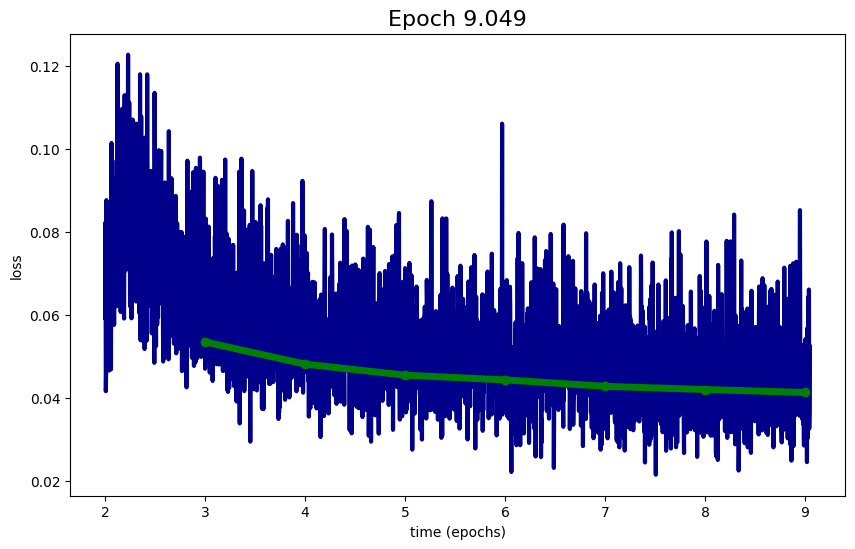

1796it [08:47,  3.47it/s]

In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()
    train(model, train_iterator, optimizer, criterion, CLIP)
    evaluate(model, test_iterator, criterion)
    end_time = time.time()
    if val_loss[-1] < best_val_loss:
        best_val_loss = val_loss[-1]
        torch.save(model.state_dict(), f'transformer_{epoch+1}.pt')
